## Testing Manual Particle Movement Experiment Calibration


In [1]:
import os
import re
import numpy as np
import librosa
import scipy.signal
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

#### Import calibration file and checking left and right gain to see which is the impact pipe

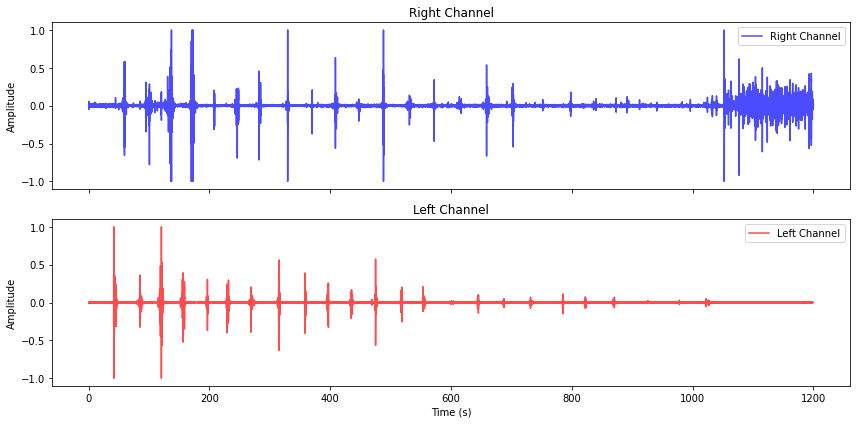

In [ ]:
filepath = 'ManualRockMovements-1/audio/Nicole_091823-000100.flac'

# load stereo signal
signal, sr = librosa.load(filepath, sr=None, mono=False)
left_channel = signal[0]
right_channel = signal[1]

#create the time axis
duration = signal.shape[-1] / sr
time = np.linspace(0, duration, signal.shape[-1])

# plot the signals
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# plot the right channel (top)
axes[0].plot(time, signal[1], label='Right Channel', color='b', alpha=0.7)
axes[0].set_title("Right Channel")
axes[0].set_ylabel("Amplitude")
axes[0].legend()

# plot the left channel (bottom)
axes[1].plot(time, signal[0], label='Left Channel', color='r', alpha=0.7)
axes[1].set_title("Left Channel")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].legend()

# adjust layout to prevent overlap
plt.tight_layout()
plt.show()


The left channel is the impact pipe. This is true for all calibration recordings for H1 in 2023

#### Compute and plotting envelope

In [ ]:
# === USER INPUT ===
left_gain_db = 6   # replace with your left channel gain
right_gain_db = 12 # replace with your right channel gain
use_channel = "left"  # or "right"

# Convert dB gain to linear
left_gain = 10 ** (left_gain_db / 20)
right_gain = 10 ** (right_gain_db / 20)

# Load stereo audio
y_stereo, sr = librosa.load("Nicole_091823-000100.flac", sr=None, mono=False)

# Choose channel and correct for gain
y = y_stereo[0] if use_channel == "left" else y_stereo[1]
gain_correction = left_gain if use_channel == "left" else right_gain
y = y / gain_correction  # undo preamp gain

# Compute envelope
analytic_signal = hilbert(y)
envelope = np.abs(analytic_signal)

# Estimate dynamic threshold (adjust multiplier as needed)
noise_level = np.median(envelope)
threshold = 5 * noise_level

# Detect packet start/end points
above_thresh = envelope > threshold
packet_starts = np.where(np.diff(above_thresh.astype(int)) == 1)[0]
packet_ends = np.where(np.diff(above_thresh.astype(int)) == -1)[0]

if packet_ends[0] < packet_starts[0]:
    packet_ends = packet_ends[1:]
if len(packet_starts) > len(packet_ends):
    packet_starts = packet_starts[:-1]

# Extract max amplitudes per packet
max_amplitudes = [np.max(np.abs(y[start:end])) for start, end in zip(packet_starts, packet_ends)]

# Plot envelope with threshold
plt.figure(figsize=(12, 4))
plt.plot(envelope, label="Envelope")
plt.axhline(threshold, color='r', linestyle='--', label=f"Threshold = {threshold:.4f}")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.legend()
plt.title(f"Envelope and Packet Threshold — Channel: {use_channel.capitalize()}")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot amplitude histogram
plt.figure(figsize=(8, 4))
plt.hist(max_amplitudes, bins=50, color='dodgerblue', edgecolor='black')
plt.xlabel("Max amplitude per packet (normalized)")
plt.ylabel("Count")
plt.title("Packet-based Amplitude Histogram")
plt.tight_layout()
plt.grid(True)
plt.show()

